In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'random/'
featurefolder = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
features = ['megno']

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

# Fraction not chaotic over 1e4 orbits

In [7]:
(testX['megno']<2.5).sum()/testX['megno'].shape[0]

0.6908145580589254

# Fraction not chaotic over 1e4 orbits that were stable

In [8]:
regular = testX['megno'] < 2.5
testY[regular].sum()/testY.shape[0]

0.5500866551126516

# Fraction chaotic over 1e4 orbits that were stable

In [10]:
chaotic = testX['megno'] > 2.5
testY[chaotic].sum()/testY.shape[0]

0.015944540727902946

In [4]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9058166                                           
ERROR                                               
0.010491271860645354                                
HOLDOUT SCORE                                       
0.9211287659279752                                  
SCORE:                                                                        
0.8984302600000001                                                            
ERROR                                                                         
0.009742971470076531                                                          
HOLDOUT SCORE                                                                 
0.9153068501298107                                                            
SCORE:                                                                        
0.90353598                                                                    
ERROR                                             

0.009365301338772553                                                           
HOLDOUT SCORE                                                                  
0.917625491803439                                                              
SCORE:                                                                         
0.9042448200000001                                                             
ERROR                                                                          
0.009693724639401593                                                           
HOLDOUT SCORE                                                                  
0.9205337595792843                                                             
SCORE:                                                                         
0.9032971599999999                                                             
ERROR                                                                          
0.009427850621429392                    

In [7]:
best

{'x_learning_rate': 0.1331413549121525,
 'x_max_depth': 5,
 'x_min_child': 1.0,
 'x_pos_weight': 3.6003211626633753,
 'x_subsample': 0.9141729386179559,
 'x_tree_colsample': 0.5801416810771934}

In [8]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.906084+0.00335344	test-auc:0.900225+0.0101204
[1]	train-auc:0.9077+0.00362617	test-auc:0.901016+0.0103774
[2]	train-auc:0.909327+0.00263831	test-auc:0.903247+0.0105024
[3]	train-auc:0.910548+0.00312172	test-auc:0.903513+0.0106735
[4]	train-auc:0.911138+0.00282604	test-auc:0.903472+0.0104685
[5]	train-auc:0.911335+0.00289699	test-auc:0.903529+0.0105862
[6]	train-auc:0.912208+0.00268104	test-auc:0.904387+0.0108742
[7]	train-auc:0.912516+0.00251288	test-auc:0.904545+0.0109374
[8]	train-auc:0.913221+0.00270888	test-auc:0.905269+0.0105721
[9]	train-auc:0.913808+0.00250702	test-auc:0.905297+0.010754
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.906084       0.003353       0.900225      0.010120
1        0.907700       0.003626       0.901016      0.010377
2        0.909327       0.002638       0.903247      0.010502
3        0.910548       0.003122       0.903513      0.010673
4        0.911138       0.002826       0.903472      0.010469
5        0.

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5801416810771934, gamma=0,
       learning_rate=0.1331413549121525, max_delta_step=0, max_depth=5,
       min_child_weight=1.0, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=3.6003211626633753,
       seed=None, silent=True, subsample=0.9141729386179559)

Text(0.5, 1.0, 'ROC curve (AUC = 0.920)')

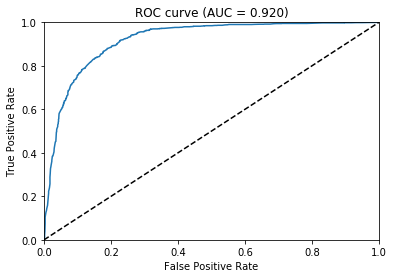

In [10]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [11]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.025752047076821327, recall = 1.0, precision = 0.5660311958405546
Threshold 0.059671636670827866, recall = 0.9975505205143906, precision = 0.6085169966380276
Threshold 0.07589183747768402, recall = 0.9951010410287814, precision = 0.6296009298721426
Threshold 0.1013232097029686, recall = 0.994488671157379, precision = 0.6485623003194888
Threshold 0.11906891316175461, recall = 0.9914268218003675, precision = 0.6687319289549772
Threshold 0.14438396692276, recall = 0.9902020820575628, precision = 0.6842996191282268
Threshold 0.1768466830253601, recall = 0.9902020820575628, precision = 0.6930990141448778
Threshold 0.21675440669059753, recall = 0.9865278628291488, precision = 0.712516585581601
Threshold 0.2534058094024658, recall = 0.9834660134721371, precision = 0.728344671201814
Threshold 0.28818225860595703, recall = 0.9810165339865279, precision = 0.7413234613604812
Threshold 0.31972700357437134, recall = 0.9797917942437232, precision = 0.7525870178739417
Threshold 0.370825737

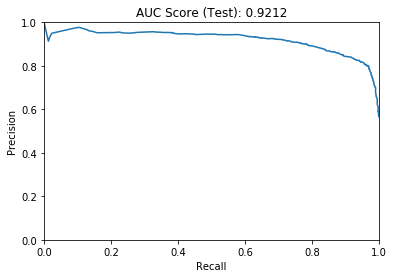

In [12]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

In [19]:
Unstable.shape

(1252,)

In [20]:
Stable.shape

(1633,)

(0, 933.9000000000001)

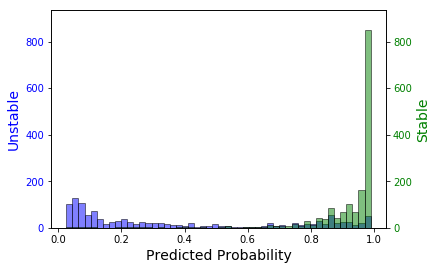

In [23]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

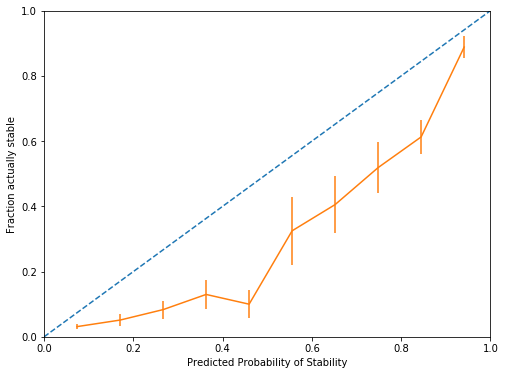

In [24]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

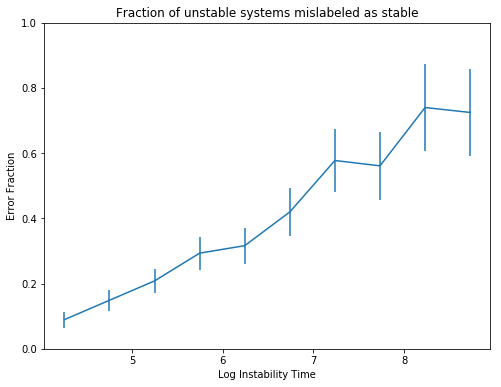

In [25]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

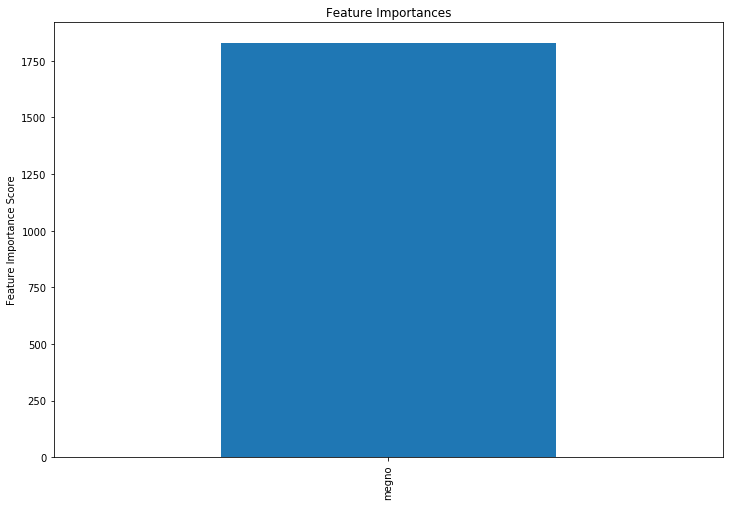

In [26]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [27]:
dill.dump([model, features, featurefolder], open(datapath+"../models/megnoxgb_random.pkl", "wb"))